In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from plot_utils import plot_results


In [6]:
titanic = pd.read_csv('Titanic.csv')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Ready datasets

First clean up the data a little

In [ ]:
#one-hot encode categorical features
male_column = pd.get_dummies(titanic["Sex"])[['male']]

#replace categorical features with new features
titanic = pd.concat([titanic, male_column], axis='columns').drop(['Sex', 'Embarked'], axis='columns')

#drop non-categorical text features, redundant features and primary key
titanic = titanic.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Fare'], axis='columns')

#drop data with NaN values
titanic = titanic.dropna()

titanic

,Survived,Pclass,Age,SibSp,Parch,male
0,0,3,22.0,1,0,True
1,1,1,38.0,1,0,False
2,1,3,26.0,0,0,False
3,1,1,35.0,1,0,False
4,0,3,35.0,0,0,True
...,...,...,...,...,...,...
885,0,3,39.0,0,5,False
886,0,2,27.0,0,0,True
887,1,1,19.0,0,0,False
889,1,1,26.0,0,0,True


Train and test sets

In [ ]:
y = titanic['Survived']
X = titanic.drop('Survived', axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=504, test_size=.2)


# Training a random forest

Let's get ourselves a baseline

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=504, max_depth=6)
tree_clf.fit(X_train, y_train)
tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test)

(0.8704028021015762, 0.7902097902097902)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Default is to train 100 trees
forest_clf = RandomForestClassifier(random_state=504, max_depth=6)
forest_clf.fit(X_train, y_train)

forest_clf.score(X_train, y_train), forest_clf.score(X_test, y_test)

(0.8756567425569177, 0.8251748251748252)

It appears that the ensemble can be an improvement (albeit small) on even a good estimator, but let's dig a bit deeper.

Let's see how the number of estimators influences the result.

c:\Users\oih\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


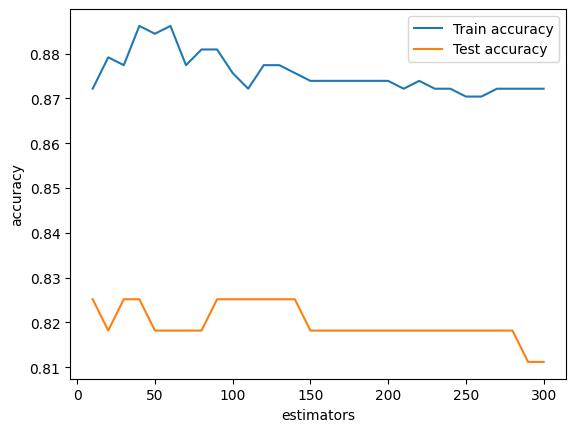

In [ ]:
estimators = [n * 10 for n in range(1, 31)]

classifiers = [RandomForestClassifier(random_state=504, warm_start=True, oob_score=True, max_depth=6, n_estimators=n) for n in estimators]
for clf in classifiers: clf.fit(X_train, y_train)

train_scores = [clf.score(X_train, y_train) for clf in classifiers]
test_scores = [clf.score(X_test, y_test) for clf in classifiers]
plot_results(train_scores, test_scores, train_label="Train accuracy", test_label="Test accuracy", xlabel="estimators", ylabel="accuracy", xvalues = estimators)

You will note that the accuracy is fluctuating some due to the randomness of the random forest.

Let's look at the Out-Of-Box score

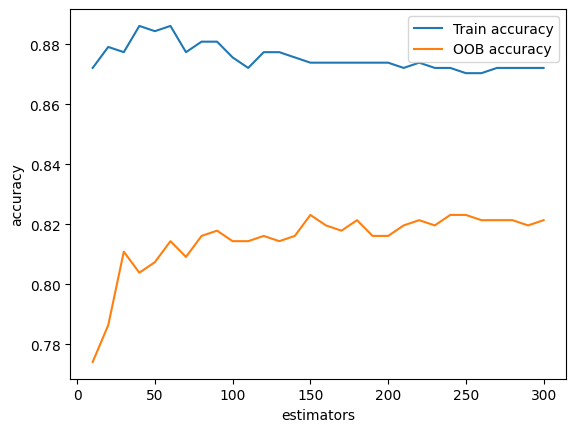

In [ ]:
oob_scores = [clf.oob_score_ for clf in classifiers]
plot_results(train_scores, oob_scores, train_label="Train accuracy", test_label="OOB accuracy", xlabel="estimators", ylabel="accuracy", xvalues = estimators)


After 20 - 40 trees (depending on the hyperparameters) there is not much improvement - just noise.

In [ ]:
forest_clf = RandomForestClassifier(random_state=504, max_depth=5, n_estimators=30)
forest_clf.fit(X_train, y_train)
forest_clf.score(X_train, y_train), forest_clf.score(X_test, y_test)

(0.8563922942206655, 0.8321678321678322)

In [ ]:
importances = zip(X_train.keys(), forest_clf.feature_importances_) #pairs up feature names with performance score
sorted(importances, key=lambda p: -p[1])

[('male', 0.46626128222447644),
 ('Pclass', 0.2246612359855532),
 ('Age', 0.20504271031403445),
 ('SibSp', 0.06283423172585344),
 ('Parch', 0.0412005397500825)]

There are improvements to be had by using ensembles on overfitting estimators, but on good estimators there is not much to gain. With max_depth=3, you won't see an improvement. 

A forest is quite robust, but you need *some* constraint(s). With no max_depth the forest is overfitting, too.